In [3]:
import pickle as pkl
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cv2
import gurobipy as gbp
%matplotlib inline

In [49]:
class RouterAllocation(object):
    
    def __init__(self, instance, update_s=False):
        """
        Inicializa a classe, recebendo uma configuração de instancia.
        
        input: dict 
            like: 
            {
                'router_types': router,
                'router_spots': grid_router,
                'client_spots': grid_clients,
                'client_min_sig': Ak,
                'name': 'instance0'
            }
        """
        self.update = update_s
        
        self.Ak           = instance['client_min_sig']
        self.grid_router  = instance['router_spots']
        self.grid_clients = instance['client_spots']
        self.routers      = instance['router_types']
        self.name         = instance['name']
        
        self.r_j = len(self.grid_router)
        self.r_k = len(self.grid_clients)
        self.r_i = len(self.routers.keys())
        
        self.compute_contributions()
        self.generate_model()
        print('Pronto pra rodar!')
    
    def signal_strength(self, xe, ye, xr, yr, router):
        d = np.linalg.norm([[xe - xr], [ye - yr]])
        return router['k'] / np.square(d) if d else np.inf

    def run(self):
        self.m.optimize()
        for v in self.m.getVars():
            if v.x: print(v.varName, v.x)
        print('Obj:', self.m.objVal)
        self.plot_solution()
    
    def compute_contributions(self):
        print('Calculando contribuição dos roteadores...')
        try:
            self.Sijk       = pkl.load(open("Sijk_%s.p" % self.name, "rb"))
            self.AnalogSijk = pkl.load(open("AnalogSijkSijk_%s.p" % self.name, "rb"))
            assert not(self.update)
        except:
            self.AnalogSijk = np.array([[[self.signal_strength(xe, ye, xr, yr, router)  
                                        for xr, yr in self.grid_clients] 
                                        for xe, ye in self.grid_router] 
                                        for _, router in self.routers.items()])
            
            self.Sijk = np.array([[[1 if self.AnalogSijk[i, j, k] > self.Ak[k] else 0  
                                    for k, (xr, yr) in enumerate(self.grid_clients)]
                                    for j, (xe, ye) in enumerate(self.grid_router)] 
                                    for i, router in self.routers.items()])
            
            pkl.dump(self.AnalogSijk, open("AnalogSijkSijk_%s.p" % self.name, "wb"))     
            pkl.dump(self.Sijk      , open("Sijk_%s.p" % self.name, "wb"))     
        
    def plot_solution(self):
        
        Rij = np.array([v.x for v in self.m.getVars()]).reshape((self.r_i, self.r_j))
        
        client_points_x = len(np.unique([a[0] for a in self.grid_clients]))
        client_points_y = len(np.unique([a[1] for a in self.grid_clients]))
        
        potencia = np.array([np.log10(np.sum([Rij[i, j] * self.AnalogSijk[i, j, k] 
                                              for j in range(self.r_j) 
                                              for i in range(self.r_i)])) 
                                              for k in range(self.r_k)]).reshape(client_points_x, client_points_y)

        fig, ax = plt.subplots(figsize=(10,10))
        c = ax.pcolor(potencia)
        fig.colorbar(c, ax=ax)
        ax.set_title('Instancia %s' % self.name)
        ax.set_xlabel('Coordenada X (m)')
        ax.set_ylabel('Coordenada Y (m)');
    
    def generate_model(self):
        """
        Monta o modelo com os dados da instancia.

        """
        print('Gerando modelo...')
        self.m = gbp.Model("Alocação de roteadores")

        # variaveis
        Xij = np.array([[self.m.addVar(vtype=gbp.GRB.BINARY, name="X %d,%d" % (i, j)) for j in range(self.r_j)] for i in range(self.r_i)])

        # função objetivo
        Ci = [r['c'] for r in self.routers.values()]

        obj = gbp.LinExpr()
        for j in range(self.r_j): 
            for i in range(self.r_i): 
                obj += Ci[i] * Xij[i, j]
        self.m.setObjective(obj, gbp.GRB.MINIMIZE)

        ## restrições
        # maximo 1 roteador por ponto no grid
        for j in range(self.r_j):
            rest = gbp.LinExpr()
            for i in range(self.r_i): rest += Xij[i, j]
            self.m.addConstr(rest <= 1, "r %d" % j)

        for k in range(self.r_k): 
            rest = gbp.LinExpr()
            for i in range(self.r_i): 
                for j in range(self.r_j):
                    rest += Xij[i, j] * self.Sijk[i, j, k]
            self.m.addConstr(rest >= 1, "s %d" % k)

### Gerar instancias

In [44]:
# area
x = 200
y = 200

# 
router_points_x = 20
router_points_y = 20

client_points_x = 20
client_points_y = 20

# tipos de roteador
routers = {
    0: {'k': 10, 'c': 100},
    1: {'k': 20, 'c': 200},
    2: {'k': 30, 'c': 300},
    3: {'k': 40, 'c': 400},
    4: {'k': 50, 'c': 500},
    5: {'k': 60, 'c': 600}
}

r_j = router_points_x * router_points_y
r_k = client_points_x * client_points_y
r_i = len(routers.keys())


grid_router = list(it.product(np.linspace(0, x-1, router_points_x, dtype=np.int), np.linspace(0, y-1, router_points_y, dtype=np.int)))
grid_clients = list(it.product(np.linspace(0, x-1, client_points_x, dtype=np.int)+1, np.linspace(0, y-1, client_points_y, dtype=np.int)+1))

# minimos
dB = -60
Ak = [10 ** (dB/20) for i in range(len(grid_clients))]

instancia0 = {
    'router_types': routers,
    'router_spots': grid_router,
    'client_spots': grid_clients,
    'client_min_sig': Ak,
    'name': 'instancia0'
}

In [31]:
router_points_x = 20
router_points_y = 20

client_points_x = 20
client_points_y = 20


r_j = router_points_x * router_points_y
r_k = client_points_x * client_points_y
r_i = len(routers.keys())

grid_router = list(it.product(np.linspace(0, x-1, router_points_x, dtype=np.int), np.linspace(0, y-1, router_points_y, dtype=np.int)))
grid_clients = list(it.product(np.linspace(0, x-1, client_points_x, dtype=np.int)+1, np.linspace(0, y-1, client_points_y, dtype=np.int)+1))

# minimos
dB = -40
Ak = [10 ** (dB/20) for i in range(len(grid_clients))]
instancia = {
    'router_types': routers,
    'router_spots': grid_router,
    'client_spots': grid_clients,
    'client_min_sig': Ak,
    'name': 'instancia1'
}

In [32]:
# minimos
dB = -60
Ak = [10 ** (dB/20) for i in range(len(grid_clients))]
routers = {
    0: {'k': 10, 'c': 100},
    1: {'k': 20, 'c': 120},
    2: {'k': 30, 'c': 140},
    3: {'k': 40, 'c': 160},
    4: {'k': 50, 'c': 170},
    5: {'k': 60, 'c': 200}
}

instancia2 = {
    'router_types': routers,
    'router_spots': grid_router,
    'client_spots': grid_clients,
    'client_min_sig': Ak,
    'name': 'instancia2'
}

In [33]:
# 
router_points_x = 10
router_points_y = 10

client_points_x = 20
client_points_y = 20


r_j = router_points_x * router_points_y
r_k = client_points_x * client_points_y
r_i = len(routers.keys())

grid_router = list(it.product(np.linspace(0, x-1, router_points_x, dtype=np.int), np.linspace(0, y-1, router_points_y, dtype=np.int)))
grid_clients = list(it.product(np.linspace(0, x-1, client_points_x, dtype=np.int)+1, np.linspace(0, y-1, client_points_y, dtype=np.int)+1))
dB = -60
Ak = [10 ** (dB/20) for i in range(len(grid_clients))]
instancia3 = {
    'router_types': routers,
    'router_spots': grid_router,
    'client_spots': grid_clients,
    'client_min_sig': Ak,
    'name': 'instancia3'
}

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Optimize a model with 800 rows, 2400 columns and 800770 nonzeros
Variable types: 0 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 500.0000000
Presolve removed 0 rows and 554 columns (presolve time = 5s) ...
Sparsify removed 527491 nonzeros (91%)
Presolve removed 0 rows and 267 columns
Presolve time: 8.82s
Presolved: 800 rows, 2133 columns, 51543 nonzeros
Variable types: 287 continuous, 1846 integer (1846 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.600000e+01   0.000000e+00      9s
      63    3.0000000e+02   0.000000e+00   0.000000e+00      9s

Root relaxation: objective 3.000000e+02, 63 iterations, 0.05 seconds

    Nodes    |    Current Node   

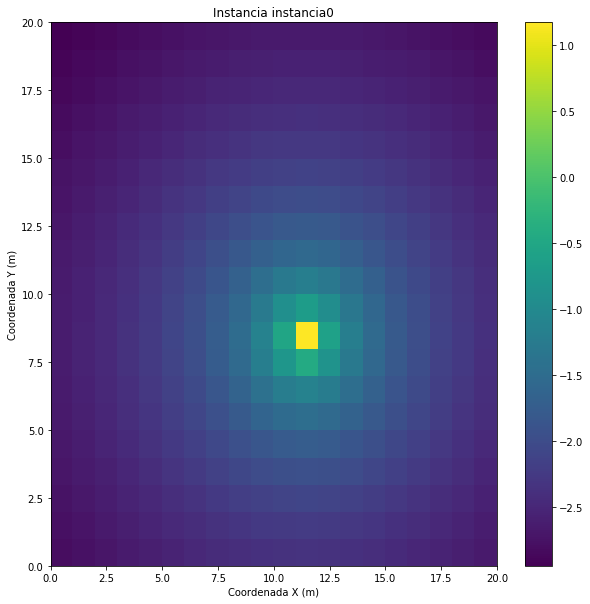

In [47]:
opt = RouterAllocation(instancia0, update_s=True)
opt.run()

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Optimize a model with 800 rows, 2400 columns and 185519 nonzeros
Variable types: 0 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3600.0000000
Presolve removed 16 rows and 0 columns
Presolve time: 1.98s
Presolved: 784 rows, 2400 columns, 180671 nonzeros
Variable types: 0 continuous, 2400 integer (2400 binary)

Root relaxation: objective 1.600000e+03, 727 iterations, 0.35 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1600.0000000 1600.00000  0.00%     -    2s

Explored 0 nodes (727 simplex iterations) in 2.54 seconds
Thread count was 2 (of 2 available processors)

Solution count 2: 

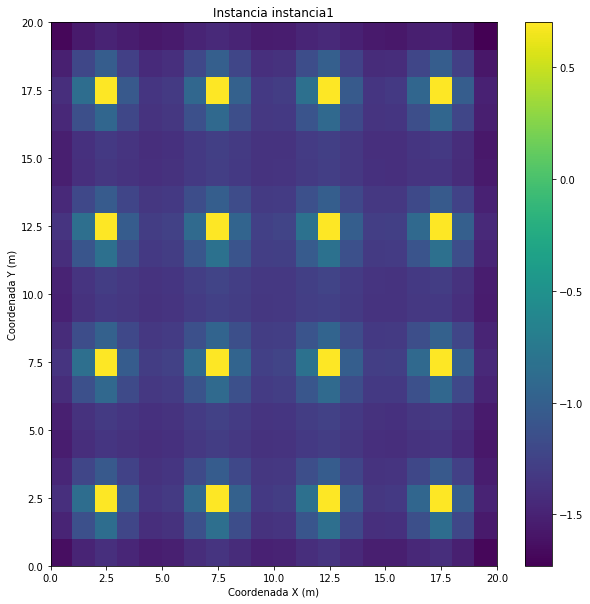

In [39]:
opt = RouterAllocation(instancia)
opt.run()

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Optimize a model with 800 rows, 2400 columns and 800770 nonzeros
Variable types: 0 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 340.0000000
Presolve removed 0 rows and 379 columns (presolve time = 5s) ...
Sparsify removed 597327 nonzeros (92%)
Presolve removed 0 rows and 91 columns
Presolve time: 7.67s
Presolved: 800 rows, 2309 columns, 51464 nonzeros
Variable types: 288 continuous, 2021 integer (2021 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.200000e+01   0.000000e+00      8s
      18    1.4000000e+02   0.000000e+00   0.000000e+00      8s

Root relaxation: objective 1.400000e+02, 18 iterations, 0.05 seconds

    Nodes    |    Current Node    

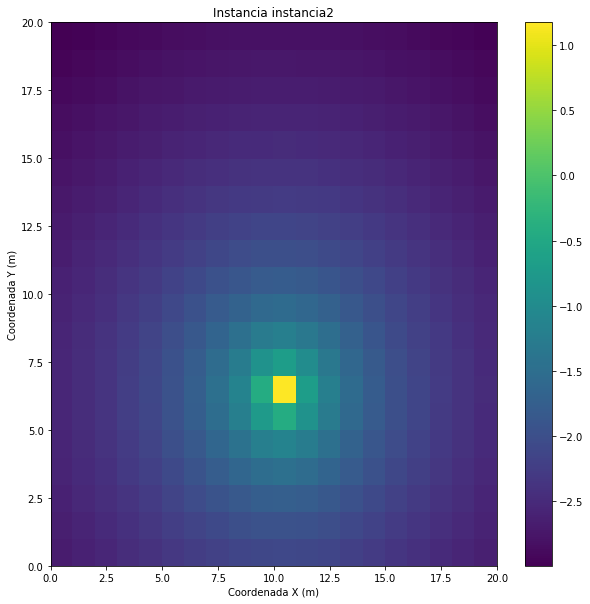

In [48]:
opt = RouterAllocation(instancia2, update_s=True)
opt.run()

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Optimize a model with 240500 rows, 600 columns and 480600 nonzeros
Variable types: 0 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+01]
  Objective range  [1e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 3e+01]
Found heuristic solution: objective 160.0000000
Presolve removed 240500 rows and 600 columns
Presolve time: 0.33s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.45 seconds
Thread count was 1 (of 2 available processors)

Solution count 2: 140 160 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+02, best bound 1.400000000000e+02, gap 0.0000%
X 2,35 1.0
Obj: 140.0


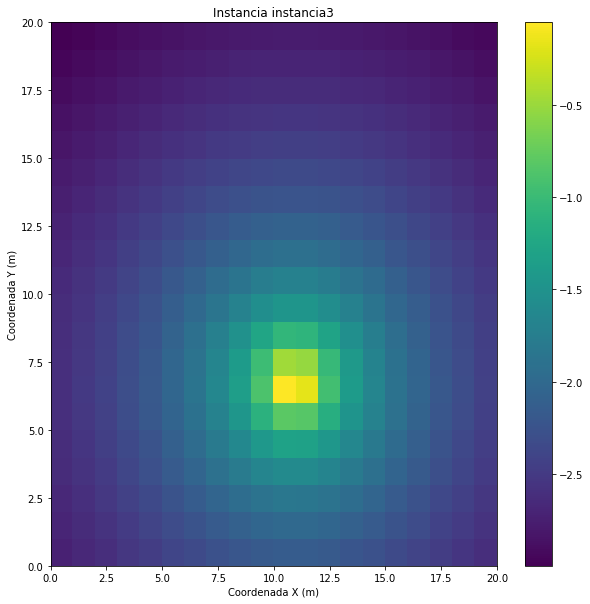

In [21]:
opt = RouterAllocation(instancia3)
opt.run()